<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Application Programming Interface, Natural Language Processing & Classification Modelling

### Contents:
- [Data Import & Cleaning](#Data-Import-and-Cleaning)


- [Modelling](#Modelling)
    - [Creating a Base Logistic Regression Model](#Creating-a-Base-Logistic-Regression-Model)


- [Hyperparameter Tuning](#Hyperparameter-Tuning)
    - [Using Different Transformers With Logistic Regression](#Using-Different-Transformers-With-Logistic-Regression)
    - [Testing a Combination of TF-IDF and Alternative Models](#Testing-a-Combination-of-TF-IDF-and-Alternative-Models)
    - [Evaluation of TFIDFVectorizer Logistic Regression](#Evaluation-of-TFIDFVectorizer-Logistic-Regression)
    - [Conclusion](#Conclusion)


- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

## Data Import and Cleaning

In [1]:
# for data visualisation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for pre-processing
import pandas as pd
import string
import re
import nltk

# for vectorizing
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, TfidfTransformer, TfidfVectorizer, HashingVectorizer

# for modelling
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_roc_curve, plot_confusion_matrix

# for Model Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
from time import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_roc_curve, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from PIL import Image
from wordcloud import WordCloud

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_roc_curve, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [2]:
df = pd.read_csv('../data/df_sub.csv')

In [3]:
df.shape

(14046, 9)

In [4]:
df.head(1)

,subreddit,alltext,created_utc,author,is_self,score,num_comments,timestamp,post_length
0,Bitcoin,crypto influencers dorsey wood musk faceoff bw...,1626937970,ReadDailyCoin,False,1,1,2021-07-22,8


Let's drop the columns that are not necessary for the modelling

In [5]:
df = df.drop(['created_utc', 'author', 'is_self', 'score', 'num_comments', 'timestamp', 'post_length'], axis=1)

To run models on this data, all words must be numerical values.

In [6]:
df['subreddit'] = df['subreddit'].map({'Bitcoin': 1, 'ethereum': 0})

In [7]:
df.head(2)

,subreddit,alltext
0,1,crypto influencers dorsey wood musk faceoff bw...
1,1,elon musk view bitcoin july 21 2021


In [8]:
df.tail(2)

,subreddit,alltext
14044,0,singapore db private bank announced launch asi...
14045,0,mining eth phoenix miner latest 56d getting hi...


In [9]:
df.isnull().sum()

subreddit    0
alltext      8
dtype: int64

In [10]:
df.dropna(inplace=True)

In [11]:
df.isnull().sum()

subreddit    0
alltext      0
dtype: int64

In [12]:
df.shape

(14038, 2)

## Modelling

In [13]:
X = df.alltext
y = df.subreddit

In [14]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

### Creating a Base Logistic Regression Model

In [15]:
# Instantiate logistic regression model
lr = LogisticRegression(solver = 'lbfgs', max_iter = 5000)

# Vectorize

vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)
X_train_base = vectorizer.fit_transform(X_train)
X_test_base = vectorizer.transform(X_test)

# Fit model to training data
lr.fit(X_train_base, y_train)

# Evaluate model on training data
print('Accuracy score for Train data set:',lr.score(X_train_base, y_train))

# Evaluate model on testing data
print('Accuracy score for Test data set:', lr.score(X_test_base, y_test))

preds = lr.predict(X_test_base)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()


print('Specificity:', round(tn / (tn + fp),4))
print('Sensitivity:', round(tp / (tp + fn),4))

Accuracy score for Train data set: 0.9278115501519757
Accuracy score for Test data set: 0.8310541310541311
Specificity: 0.7481
Sensitivity: 0.8878


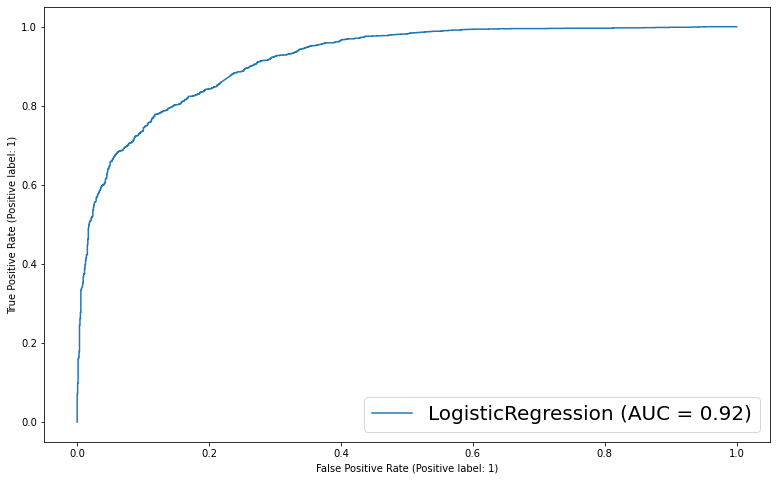

In [16]:
fig, ax = plt.subplots(figsize=(13, 8))
plot_roc_curve(lr, X_test_base, y_test, ax = ax)
plt.legend(prop={"size":20});

#### Section Conclusion
Our base logistic regression seems to be performing quite well (AUC = 0.92), the only concern, however, is model over-fitting as the train score is extremely high (0.927) and somewhat notably larger than test score (0.831). While our model performs relatively well in the sensitivity area (0.888), it leaves us wanting in the area of specificity (0.748). Given the possibility of over-fitting and our poor specificity score, we will conduct hyperparameter tuning in hopes of improving those aspects of our model.

## Hyperparameter Tuning

In this section, we perform two types of hyperparameter tuning - (i) the best vectorizer and (ii) given that vectorizer, the best classification model. To determine the best vectorizer, we test the performance of our Logistic Regression Model when used in conjunction with (i) Count Vectorizer, (ii) TFIDF Vectorizer, and (iii) Hashing Vectorizer, individually. After determining the best vectorizer, we determine the best regression model by using that vectorizer in conjunction with models: (i) K. Nearest Neighbours Classifier, (ii) Multinomial Naive Bayes, (iii) Decision Tree Classifer, (iv) Bagging Classifer, and (v) ADABoost Classifer, individually. Our hyperparameter tuning will eventually lead us to the conclusion that the best vectorizer-model pair for our Nvidia/AMD subreddit classifier is the TF-IDF-Logistic-Regression-Model.

### Using Different Transformers With Logistic Regression

#### CountVectorizer Logistic Regression

In [17]:
# Setting pipeline for two stages
cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'cvec__max_features': [3000, 4000, 5000],
    'cvec__min_df': [4, 5, 6],
    'cvec__max_df': [.5 , .6, .7],
    'cvec__ngram_range': [(1,1), (1,2)]
}

gs_cvec_lr = GridSearchCV(cvec_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.
t0 = time()
gs_cvec_lr.fit(X_train, y_train)
cvec_test_time = time() - t0
print('Best CVEC Parameters:', gs_cvec_lr.best_estimator_[0])
print('Fit time:  %0.3fs' % cvec_test_time);

Best CVEC Parameters: CountVectorizer(max_df=0.5, max_features=5000, min_df=4)
Fit time:  233.096s


#### TFIDFVectorizer Logistic Regression

In [18]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [3000, 4000, 5000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3, .4],
    'tfid__ngram_range': [(1,1), (1,2)]
}

gs_tfid_lr = GridSearchCV(tfid_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(X_train, y_train)
tfid_test_time = time() - t0
print('Best TFID Parameters:',gs_tfid_lr.best_estimator_[0])
print('Fit time:  %0.3fs' % tfid_test_time);

Best TFID Parameters: TfidfVectorizer(max_df=0.4, max_features=5000, min_df=3)
Fit time:  207.944s


#### Results After Using Different Transformers With Logistic Regression

In [19]:
print('CVEC LogReg Train Score:', gs_cvec_lr.best_score_)
print('CVEC LogReg Test Score:', gs_cvec_lr.score(X_test,y_test))
print('CVEC Fit Time:', cvec_test_time)
print('-'*10)
print('TFID LogReg Train Score:', gs_tfid_lr.best_score_)
print('TFID LogReg Test Score:', gs_tfid_lr.score(X_test,y_test))
print('TFID Fit Time:', tfid_test_time)

CVEC LogReg Train Score: 0.8279817645771723
CVEC LogReg Test Score: 0.8341880341880342
CVEC Fit Time: 233.0958924293518
----------
TFID LogReg Train Score: 0.8364356560714438
TFID LogReg Test Score: 0.845014245014245
TFID Fit Time: 207.94358325004578


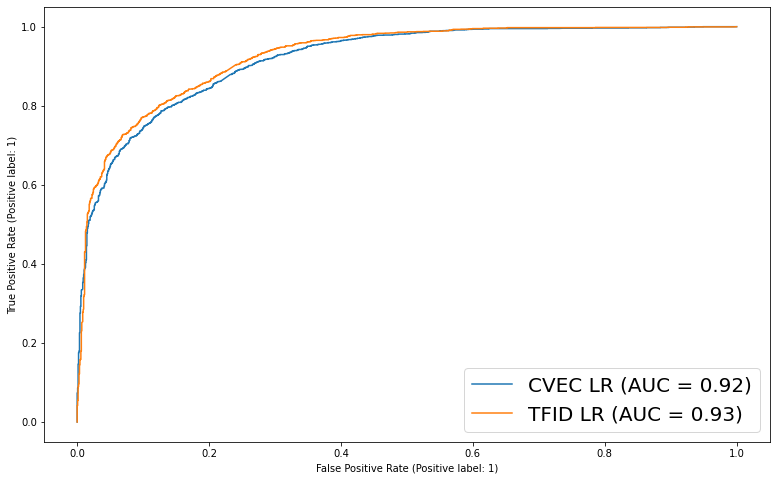

In [20]:
fig, ax = plt.subplots(figsize=(13, 8))
cvec_lr_disp = plot_roc_curve(gs_cvec_lr, X_test, y_test, name = 'CVEC LR', ax = ax)
tfid_lr_disp = plot_roc_curve(gs_tfid_lr, X_test, y_test, name = 'TFID LR', ax = ax)
plt.legend(prop={"size":20});

#### Section Conclusion
From testing different transformers, we gather that, although marginal, using TF-IDF Vectorizing yields the greatest AUC score at 0.93 when used in conjunction with logistic regression. In the next section, we take use TF-IDF on different models to see if our beloved TF-IDF-Logistic-Regression couple is the best for classifying between the Bitcoin and Ethereum subreddits.

### Testing a Combination of TF-IDF and Alternative Models

#### TFIDFVectorizer KNeighborsClassifier

In [21]:
# Setting pipeline for two stages
tfid_knn = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

pipe_params = {
    'tfid__max_features': [1000, 2000],
    'tfid__min_df': [2, 3],
    'tfid__max_df': [.2, .3],
    'tfid__ngram_range': [(1,1), (1,2)],
    'knn__n_neighbors': [10,15],
    'knn__p': [1,2]
}

gs_tfid_knn = GridSearchCV(tfid_knn, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

t0 = time()
gs_tfid_knn.fit(X_train, y_train)
knn_test_time = time() - t0
print('Best KNN Parameters:', gs_tfid_knn.best_estimator_)
print('Fit time:  %0.3fs' % knn_test_time);

Best KNN Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.2, max_features=1000, min_df=2,
                                 ngram_range=(1, 2))),
                ('knn', KNeighborsClassifier(n_neighbors=15))])
Fit time:  559.849s


#### TFIDFVectorizer Multinomial Naive Bayes

In [22]:
# Setting pipeline for two stages
tfid_nb = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tfid__max_features': [1000,2000,3000],
    'tfid__min_df': [1, 2, 3],
    'tfid__max_df': [.3, .4, .5],
    'tfid__ngram_range': [(1,1), (1,2)],
    'nb__alpha': list(np.linspace(0.1,1,5))
}

gs_tfid_nb = GridSearchCV(tfid_nb, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

t0 = time()
gs_tfid_nb.fit(X_train, y_train)
nb_test_time = time() - t0
print('Best NB Parameters:', gs_tfid_nb.best_estimator_)
print('Fit time:  %0.3fs' % nb_test_time);

Best NB Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.4, max_features=3000,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB())])
Fit time:  982.436s


#### TFIDFVectorizer DecisionTreeClassifier

In [26]:
# Setting pipeline for two stages
tfid_tree = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('tree', DecisionTreeClassifier())
])

pipe_params = {
    'tfid__max_features': [1000, 2000],
    'tfid__min_df': [2, 3],
    'tfid__max_df': [.3, .4],
    'tfid__ngram_range': [(1,1), (1,2)],
    'tree__min_samples_split': [100 ,200, 300],
    'tree__ccp_alpha': [0, 0.001]
}

gs_tfid_tree = GridSearchCV(tfid_tree, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

t0 = time()
gs_tfid_tree.fit(X_train, y_train)
tree_test_time = time() - t0
print('Best TREE Parameters:', gs_tfid_tree.best_estimator_)
print('Fit time:  %0.3fs' % tree_test_time);

Best TREE Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=2000, min_df=2)),
                ('tree',
                 DecisionTreeClassifier(ccp_alpha=0.001,
                                        min_samples_split=100))])
Fit time:  624.124s


#### TFIDFVectorizer BaggingClassifier

In [24]:
# Setting pipeline for two stages
tfid_bag = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('bag', BaggingClassifier())
])

pipe_params = {
    'tfid__max_features': [2000, 3000],
    'tfid__min_df': [2, 3, 4],
    'tfid__max_df': [.3, .4, .5],
    'tfid__ngram_range': [(1,1), (1,2)]
}

gs_tfid_bag = GridSearchCV(tfid_bag, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.
t0 = time()
gs_tfid_bag.fit(X_train, y_train)
bag_test_time = time() - t0
print('Best BAG Parameters:', gs_tfid_bag.best_estimator_)
print('Fit time:  %0.3fs' % bag_test_time);

Best BAG Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.4, max_features=3000, min_df=3)),
                ('bag', BaggingClassifier())])
Fit time:  1893.611s


#### TFIDFVectorizer ADABoostClassifier

In [27]:
# Setting pipeline for two stages
tfid_ada = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('ada', AdaBoostClassifier())
])

pipe_params = {
    'tfid__max_features': [2000, 3000],
    'tfid__min_df': [3, 4],
    'tfid__max_df': [.3, .4],
    'ada__n_estimators': [50,100],
    'ada__learning_rate': [0.9, 1]
}

gs_tfid_ada = GridSearchCV(tfid_ada, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.
t0 = time()
gs_tfid_ada.fit(X_train, y_train)
ada_test_time = time() - t0
print('Best ADABoost Parameters:', gs_tfid_ada.best_estimator_)
print('Fit time:  %0.3fs' % ada_test_time);

Best ADABoost Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.4, max_features=3000, min_df=3)),
                ('ada', AdaBoostClassifier(learning_rate=1, n_estimators=100))])
Fit time:  238.116s


#### Results After Testing a Combination of TF-IDF and Alternative Models 

In [28]:
print(f'TFIDF LogReg Train Score:', gs_tfid_lr.best_score_)
print(f'TFIDF LogReg Test Score:', gs_tfid_lr.score(X_test,y_test))
print(f'LogReg Fit Time:', tfid_test_time)
print('-'*10)
print(f'TFIDF KNN Train Score:', gs_tfid_knn.best_score_)
print(f'TFIDF KNN Test Score:', gs_tfid_knn.score(X_test,y_test))
print(f'KNN Fit Time:', knn_test_time)
print('-'*10)
print(f'TFIDF NB Train Score:', gs_tfid_nb.best_score_)
print(f'TFIDF NB Test Score:', gs_tfid_nb.score(X_test,y_test))
print(f'NB Fit Time:', nb_test_time)
print('-'*10)
print(f'TFIDF TREE Train Score:', gs_tfid_tree.best_score_)
print(f'TFIDF TREE Test Score:', gs_tfid_tree.score(X_test,y_test))
print(f'TREE Fit Time:', tree_test_time)
print('-'*10)
print(f'TFIDF BAG Train Score:', gs_tfid_bag.best_score_)
print(f'TFIDF BAG Test Score:', gs_tfid_bag.score(X_test,y_test))
print(f'BAG Fit Time:', bag_test_time)
print('-'*10)
print(f'TFIDF ADABoost Train Score:', gs_tfid_ada.best_score_)
print(f'TFIDF ADABoost Test Score:', gs_tfid_ada.score(X_test,y_test))
print(f'ADABoost Fit Time:', ada_test_time)

TFIDF LogReg Train Score: 0.8364356560714438
TFIDF LogReg Test Score: 0.845014245014245
LogReg Fit Time: 207.94358325004578
----------
TFIDF KNN Train Score: 0.6701175467446252
TFIDF KNN Test Score: 0.6794871794871795
KNN Fit Time: 559.8490288257599
----------
TFIDF NB Train Score: 0.8111703469106478
TFIDF NB Test Score: 0.8116809116809117
NB Fit Time: 982.4361083507538
----------
TFIDF TREE Train Score: 0.8075619257725355
TFIDF TREE Test Score: 0.8094017094017094
TREE Fit Time: 624.1244320869446
----------
TFIDF BAG Train Score: 0.8231384597338675
TFIDF BAG Test Score: 0.8284900284900285
BAG Fit Time: 1893.6107831001282
----------
TFIDF ADABoost Train Score: 0.8131655512019724
TFIDF ADABoost Test Score: 0.8207977207977208
ADABoost Fit Time: 238.1162567138672


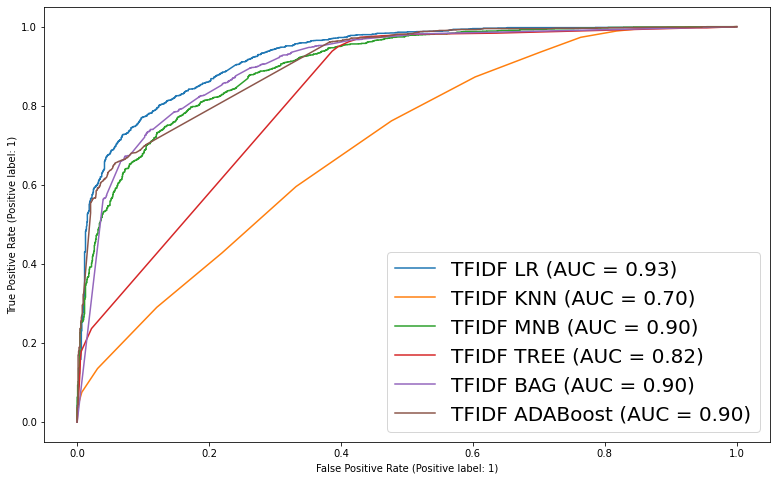

In [29]:
fig, ax = plt.subplots(figsize=(13, 8))
tfid_lr_disp = plot_roc_curve(gs_tfid_lr, X_test, y_test, name = 'TFIDF LR', ax = ax)
tfid_knn_disp = plot_roc_curve(gs_tfid_knn, X_test, y_test, name = 'TFIDF KNN', ax = tfid_lr_disp.ax_)
tfid_nb_disp = plot_roc_curve(gs_tfid_nb, X_test, y_test, name = 'TFIDF MNB', ax = tfid_lr_disp.ax_)
tfid_tree_disp = plot_roc_curve(gs_tfid_tree, X_test, y_test, name = 'TFIDF TREE', ax = tfid_lr_disp.ax_)
tfid_bag_disp = plot_roc_curve(gs_tfid_bag, X_test, y_test, name = 'TFIDF BAG', ax = tfid_lr_disp.ax_)
tfid_ada_disp = plot_roc_curve(gs_tfid_ada, X_test, y_test, name = 'TFIDF ADABoost', ax = tfid_lr_disp.ax_)
plt.legend(prop={"size":20});

#### Section Conclusion
WOW! TF-IDF-Logistic-Regression gives us the best AUC score. Although there is not a thing in the world I would love more than to continue hyperparameter turning, due to a lack of time, we conclude this section by proclaiming: with respect to our experiments, TF-IDF-Logistic-Regression is the best vectorizer-model couple for classifying between the Bitcoin and Ethereum subreddits.

### Evaluation of TFIDFVectorizer Logistic Regression

In [30]:
predictions = gs_tfid_lr.predict(X_test)

In [38]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
print('Accuracy of Bitcoin prediction:', round(tp / (tp + fn),4))
print('Accuracy of Ethereum prediction:', round(tn / (tn + fp),4))

True Negatives: 1009
False Positives: 416
False Negatives: 128
True Positives: 1957
Accuracy of Bitcoin prediction: 0.9386
Accuracy of Ethereum prediction: 0.7081


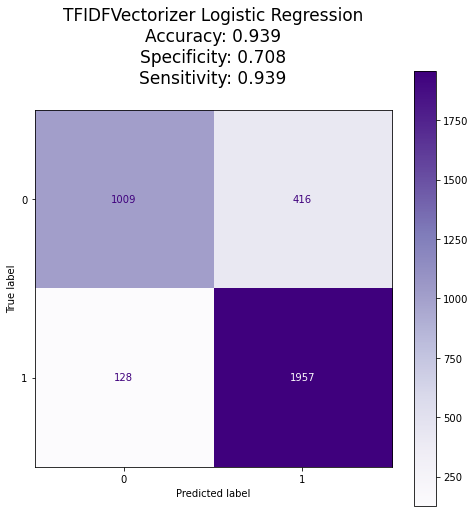

In [54]:
# Plot a confusion matrix. The greener the square, the better the result.
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('TFIDFVectorizer Logistic Regression'+ '\n'
          +'Accuracy: {:.3f}'.format(round(tp / (tp + fn),4))+'\n'
          +'Specificity: {:.3f}'.format(round(tn / (tn + fp),4))+'\n'
          +'Sensitivity: {:.3f}'.format(round(tp / (tp + fn),4))+'\n', size = 17)
plot_confusion_matrix(gs_tfid_lr, X_test, y_test, ax = ax,cmap='Purples')

#### Section Conclusion
Our test accuracy score increased from 0.83 to 0.94, meaning that by tuning the hyperparameters, the gap between the train accuracy score (0.93) and test accuracy score is reduced from 0.1 to 0.01. This indicates that model overfitting has likely been reduced. While specificity suffered a fall by 0.04, sensitivity increased by 0.05, meaning that with the hyperparameters at their optimal settings, our model is less able to classify Ethereum's subreddit's posts, but more able to classify Bitcoin's subreddit's posts.

### Conclusion

In [33]:
def fancycloud(targetimage, color, invert=False, bg="black"):
    # Create a dataframe containing the words and their coefficient
    wordcloudcontent = pd.DataFrame(data = [gs_tfid_lr.best_estimator_.named_steps['tfid'].get_feature_names(),
                     gs_tfid_lr.best_estimator_.named_steps['lr'].coef_[0]]).T.rename(columns = {0 : 'Features', 1: 'Coef'}).sort_values(by = 'Coef', ascending = invert).reset_index(drop = True)
    if invert == True:
        wordcloudcontent['Coef'] = wordcloudcontent['Coef']*-1

    # Create a dictionary where the word is the key and the coefficient is the associated value   
    freq = {}
    for i,j in wordcloudcontent.values:
        freq[i] = j
    
    # Create a mask using an image (preferably a black and white vector graphic)
    mask = np.array(Image.open(targetimage))
    
    # Generate a wordcloud function
    wordcloud = WordCloud(max_font_size=100,
                      max_words=200,
                      background_color=bg,
                      colormap=color,
                      mask = mask)
    
    # Call the function using the frequencies
    wordcloud.generate_from_frequencies(frequencies=freq)
    
    plt.figure(figsize = (14,14))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [34]:
def barplotter(title, colors,invert=False):
    # Create a dataframe containing the words and their coefficient
    wordcloudcontent = pd.DataFrame(data = [gs_tfid_lr.best_estimator_.named_steps['tfid'].get_feature_names(),
                     gs_tfid_lr.best_estimator_.named_steps['lr'].coef_[0]]).T.rename(columns = {0 : 'Features', 1: 'Coef'}).sort_values(by = 'Coef', ascending = invert).reset_index(drop = True)
    if invert == True:
        wordcloudcontent['Coef'] = wordcloudcontent['Coef']*-1
    plt.figure(figsize= (10, 6))
    plt.title(title,fontdict = {'fontsize':25})
    sns.barplot(x= wordcloudcontent['Coef'][:25], y=wordcloudcontent['Features'][:25], palette=colors)
    plt.show()

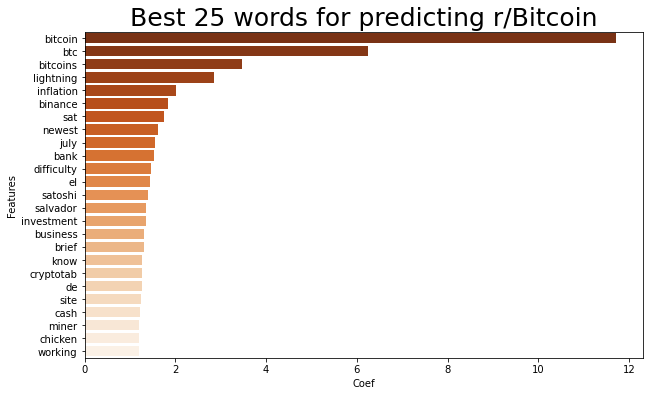

In [48]:
barplotter('Best 25 words for predicting r/Bitcoin', colors='Oranges_r')

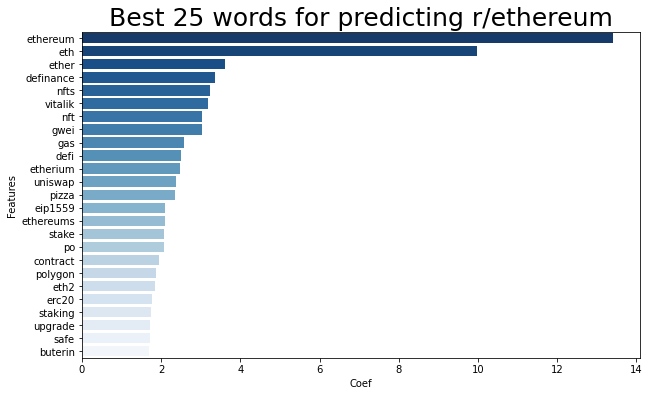

In [55]:
barplotter('Best 25 words for predicting r/ethereum', colors='Blues_r', invert = True)

## Conclusions and Recommendations

### Findings

Based on our research on the r/Bitcoin and r/ethereum subreddits, it seems that the most important words which influence the prediction of a post's subreddit are the names of the cryptocurrencies (Bitcoin, ethereum) and their short forms (btc, eth).

The word 'lightning' also features heavily in r/Bitcoin, possibly referring to The Lightning Network which is a payment protocol designed to be on top of a blockchain based currency such as Bitcoin, as well as 'satoshi' which refers to Satoshi Nakamoto, the pseudoymous person(s) who developed bitcoin, and 'salvador' probably part of posts talking about the country El Salvador makikng Bitcoin a legal currency, even offering $30 of Bitcoin to citizens to boost its use.

In r/ethereum we see 'definance' as one of the top words probably in posts talking about Decentralised finance (DeFi), which is a collective term for financial products and services which are accessible to anyone who can use Ethereum, and 'gas' appears even more frequently, most likely referring to Ethereum Gas Fees which are paid to execute specific operations on the Ethereum network (rather than referring to petrol).

Based on the above observations, it seems that our goal to build a chatbot for the company's website, as a first checkpoint for users enquiring about cryptocurrencies, is attainable as long as users input the "Best 25 words" for Bitcoin and ethereum. We recommend for the chatbot to be programmed to prompt users with keywords as a way of leading them towards making more specific inputs, thus making the classification more accurate and consistent.

We also recommend that the TFIDF Logistic Regression Model is picked as the primary method for the chatbot's classification process due to its reliability in making the right prediction as indicated by the scores.

Additionally, it would be advisable to pilot the chatbot to a targeted group of users to further determine the bot's effectiveness and consistency in classifying and responding to text enquiries accurately.

#### Limitations

The main limitation of our model currently seems to be its inferiority in classifying r/ethereum posts compared to r/Bitcoin posts. This may present an unfavourable situation in case the bot is unable to respond correctly to Ethereum related enquiries. While the pilot program is being run, we will be working behind the scenes to try and improve the model's capabilities in classifying r/ethereum posts. We might need to expose the classifier to more data or tune the hyperparameters to improve its accuracy with regards to Ethereum.

#### Future Development

Moving forward, we aim to building an ensemble model that combines different models (e.g. Naive Bayes, LogReg and/or Support Vector Machine) to deliver a more optimal performance.

We also intend to expand the scope of our algorithm to include more cryptocurrencies by extending the existing binary classifiers to multi-class classifiers.

The use of sentiment analysis to augment our core text classification is another area that has the potential to further improve the robustness of our classifier, and thus our bot.